## Fruit Image Exploration - Dimension Reduction and Clustering Study  
Nick Vastine<br>
DTSA 5510 - Unsupervised Algorithms in Machine Learning<br>
Final Project<br>
August 19, 2024

### Problem Statement
This project focuses on using unsupervised clustering algorithms and dimension reduction to classify a series of fruit images into groups. It will explore manual feature reduction methods, followed by a PCA to further reduce features. While images of fruit are not necessarily hierarchical, we will also compare k-means and agglomerative clustering methods to explore underlying patterns in our data. Finally, we will evaluate an adequate number of clusters based on inertia as an example of hyperparameter tuning.

### Data
The project sources data from a [Kaggle Fruit Classification dataset](https://www.kaggle.com/datasets/sshikamaru/fruit-recognition/data). The data includes 22,495 images, split into 75%/25% training/testing split. Since we will not be labeling entries or comparing to supervised learning methods, the data will be consolidated into a single dataset for model training.

### Exploratory Data Analysis
Below is a sample image from our dataset:

Data Shape = (100, 100, 3)


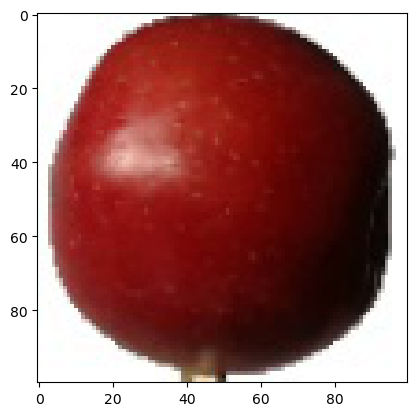

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

test_image = "./Data/train/train/Apple Braeburn/Apple Braeburn_0.jpg"
img = np.array(Image.open(test_image))
print(f"Data Shape = {img.shape}")

plt.imshow(img)

Each of our 22,495 observations are constructed as a 100x100 pixel image, where each pixel is encoded with three values from 0 to 255 to represent RGB value. This results in a (100,100,3) matrix to define each image. If flattened, this would result in _30,000 total features_! 

The following code consolidates the training/testing data into a single dataset, then provides a sampling of images at random.

In [2]:
## Data Consolidation
all_data = np.empty((22495, 100, 100, 3),dtype=int)
i = 0
for dirpath, subdirs, files in os.walk('./Data/', topdown=True): # This code walks through all paths within a directory
    for file in files: # for each file in the directory
        if file.endswith(".jpg"): # if an image
            img = Image.open(os.path.join(dirpath, file)) # open image
            img = np.asarray(img) # convert to array
            # print(img.shape)
            all_data[i] = img # append to our dataset
            i += 1 # increment the index 

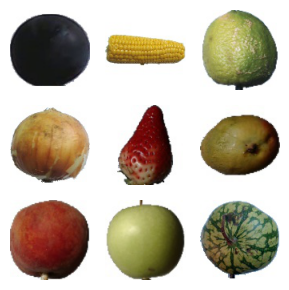

In [3]:
## Images Display
def display_images(image_data, N, figsize=(3,3)):
    selected_images = np.random.choice(image_data.shape[0], N, replace=False) # random index selection
    grid_size = int(np.ceil(np.sqrt(N))) # initialize grid dimensions
    fig, axs = plt.subplots(grid_size, grid_size, figsize=figsize) # initialize subplots
    for i, ax in enumerate(axs.flatten()):
        if i < N:
            ax.imshow(image_data[selected_images[i]]) # show image from image data, based on our random index selection
            ax.axis('off')  # Turn off axis for each subplot
        else:
            fig.delaxes(ax)  # Remove excess subplots
    plt.tight_layout()
    plt.show()

display_images(all_data,9)

As we can see, there are a diverse range of shapes, sizes, and colors to consider. Our numerical features provide a few key pieces of information that should inform our clustering:
1) Shape of the object based on overall 'intensity', for example a round apple compared to an oblong banana.
2) Color based on the RGB values

#### Model 1: Intensity

Let's first consider intensity by summing our separate RGB values into a single intensity for each pixel. Functionally this will result in a greyscale representation of the image. We will use this greyscale process as one way to reduce features for our clustering models.

Below we summ each pixel's intensity across all our samples. The below plot is a single 100x100 matrix representation of the average image if greyscale.

<Axes: >

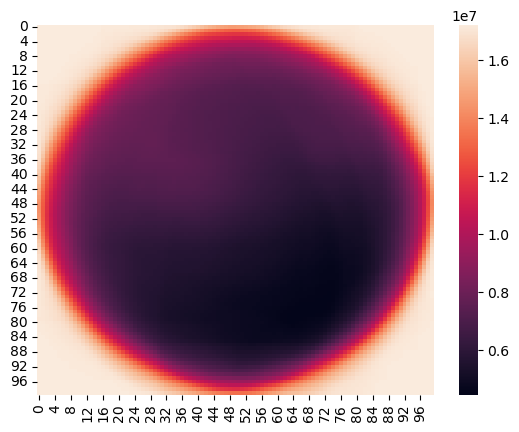

In [4]:
import seaborn as sns
all_data_pixel_sum = np.sum(all_data,axis=3) # sum all RGB intensity values to single value
all_data_sample_sum = np.sum(all_data_pixel_sum, axis = 0) # sum all samples for each pixel
sns.heatmap(all_data_sample_sum) # plot heatmap

Unsurprisingly, we see a circle since most of the samples are circular. Since higher values of 'intensity' are closer to white (RGB 0,0,0 is black, while RGB 255,255,255 is white), we see the white background clearly distinguised with higher values. We also see a literal (and representative) shadow on the lower right of the shape where there is less overall intensity, indicating a darker area or part of the 100x100 image which is used by more samples.

#### Model 2: Color Histogram

Instead of condensing each color's intensity to a single value, let's consider a method that isolates the color presence from our RGB dimensions. Let's look at a sample to understand the underlying code.

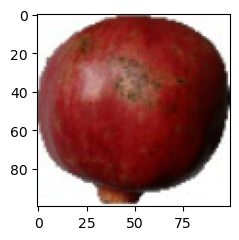

In [5]:
image = all_data[1000]
fig,ax = plt.subplots(figsize=(2.5, 2.5))
plt.imshow(image)

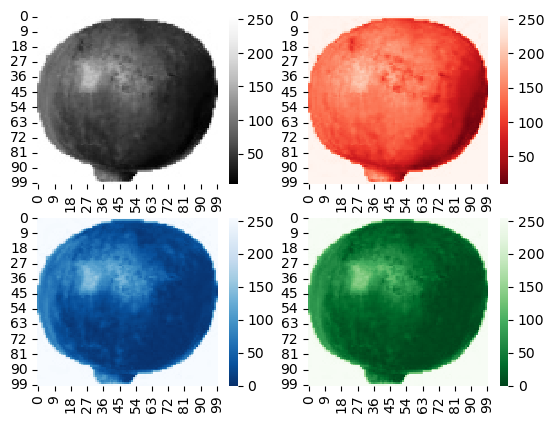

In [6]:
def color_arrays(image):
    intensity_array = np.sum(image,axis=2)/3
    red_array = image[:,:,0]
    blue_array = image[:,:,1]
    green_array = image[:,:,2]
    return intensity_array, red_array, blue_array, green_array

def plot_heatmaps(intensity_array, red_array, blue_array, green_array):
    plt.subplot(2,2,1)
    sns.heatmap(intensity_array,cmap="Greys_r")
    plt.subplot(2,2,2)
    sns.heatmap(red_array,cmap="Reds_r")
    plt.subplot(2,2,3)
    sns.heatmap(blue_array,cmap="Blues_r")
    plt.subplot(2,2,4)
    sns.heatmap(green_array,cmap="Greens_r")

intensity_array, red_array, blue_array, green_array = color_arrays(image)
plot_heatmaps(intensity_array, red_array, blue_array, green_array)

Above isolates the R,G, and B components of our data into separate datasets, which we then plot as a heatmap. Again areas of lower value are darker, while areas of high value are lighter. Areas where R, G, and B all have high values indicate a white area on the original image, in this case the background.

From this color data, we can create histograms each color value, binning from 0-255. Note these histograms disregard the relationship _between pixels_ and look purely at the count of each pixel's color value across the image.

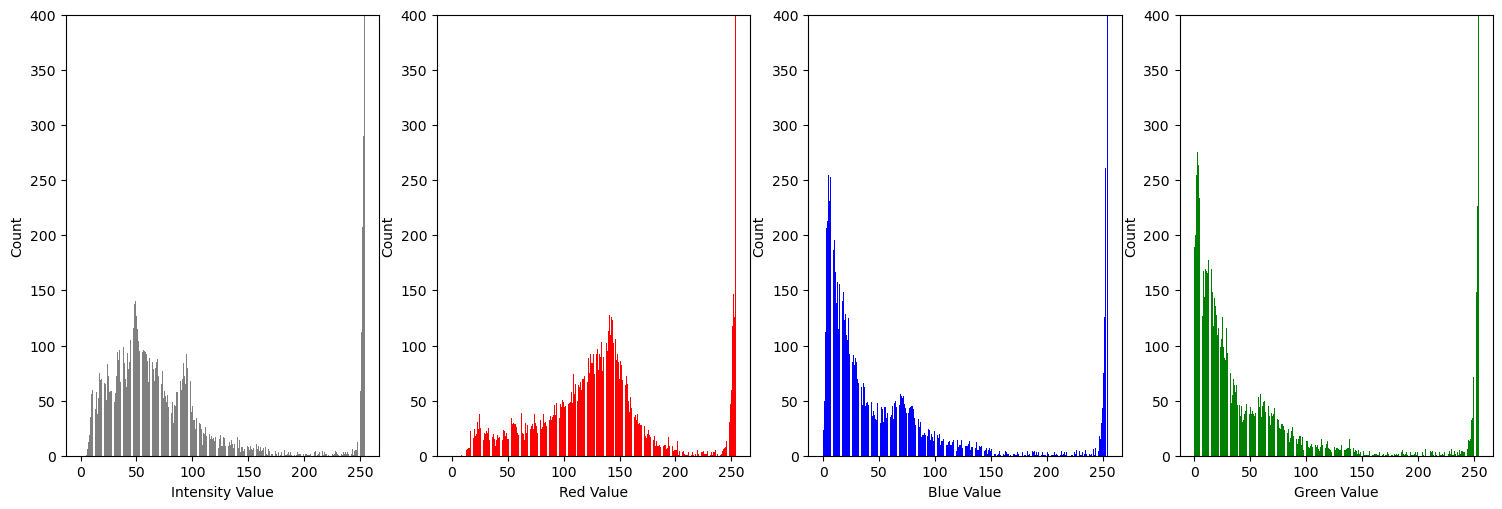

In [7]:
def color_hist(intensity_array, red_array, blue_array, green_array):
    bins=np.arange(0, 255)
    intensity_hist, _ = np.histogram(intensity_array.flatten(), bins=np.arange(0, 256))
    red_hist, _ = np.histogram(red_array.flatten(), bins=np.arange(0, 256))
    blue_hist, _ = np.histogram(blue_array.flatten(), bins=np.arange(0, 256))
    green_hist, _ = np.histogram(green_array.flatten(), bins=np.arange(0, 256))
    return intensity_hist, red_hist, blue_hist, green_hist

def plot_hist(intensity_hist, red_hist, blue_hist, green_hist):
    bins=np.arange(0, 255)
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    fig.tight_layout()
    axs[0].bar(bins, intensity_hist, color="grey")
    axs[0].set_ylim([0, 400])
    axs[0].set_xlabel("Intensity Value")
    axs[0].set_ylabel("Count")

    axs[1].bar(bins, red_hist, color="red")
    axs[1].set_ylim([0, 400])
    axs[1].set_xlabel("Red Value")
    axs[1].set_ylabel("Count")
    
    axs[2].bar(bins, blue_hist, color="blue")
    axs[2].set_ylim([0, 400])
    axs[2].set_xlabel("Blue Value")
    axs[2].set_ylabel("Count")
    
    axs[3].bar(bins, green_hist, color="green")
    axs[3].set_ylim([0, 400])
    axs[3].set_xlabel("Green Value")
    axs[3].set_ylabel("Count")

intensity_hist, red_hist, blue_hist, green_hist = color_hist(intensity_array, red_array, blue_array, green_array)
plot_hist(intensity_hist, red_hist, blue_hist, green_hist)

The left side of the histogram represents darker values, so the provided image has lots of blue and green in the shadows. As we move to the right, we see the color of the highlights, in this case almost exclusively red. Finally the spike around 250 describes the white background, and as such this spike will be present among all our samples. While I've also included a plot of an equivalent 'intensity' to the left, this is not included in the final dataset.

Let's look at another example to show how these histograms can vary.

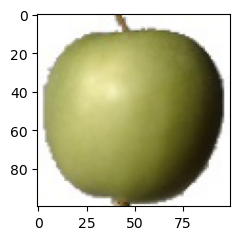

In [8]:
image = all_data[200]  # images[1]]
fig,ax = plt.subplots(figsize=(2.5, 2.5))
plt.imshow(image)

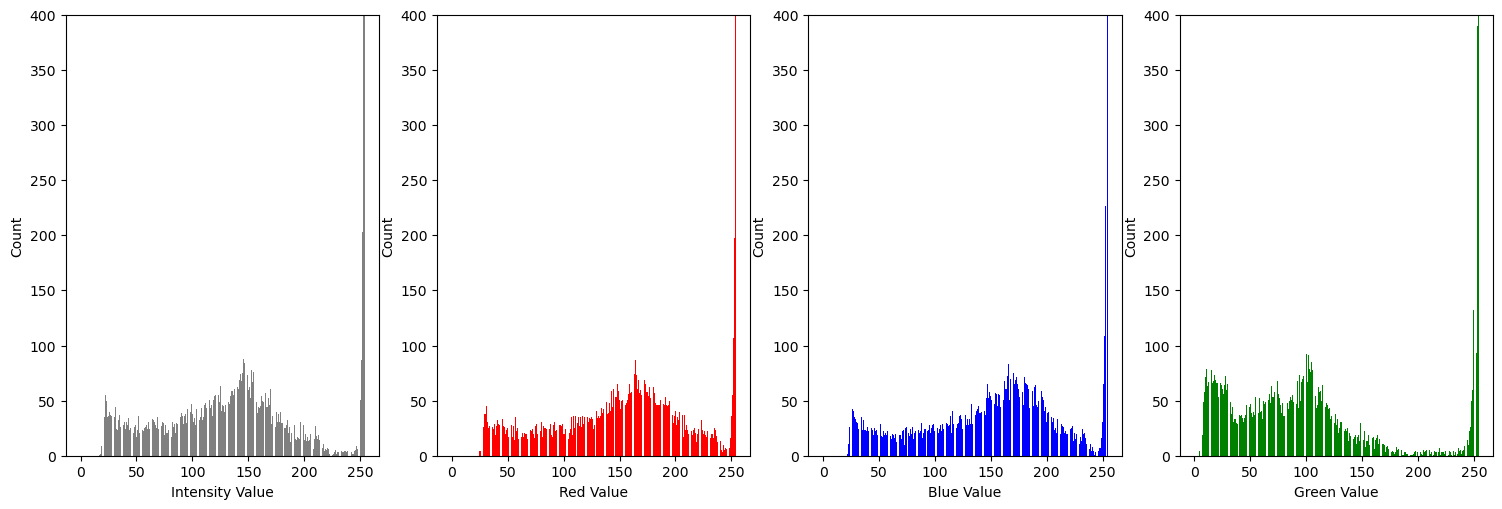

In [9]:
intensity_array, red_array, blue_array, green_array = color_arrays(image)
# plot_heatmaps(intensity_array, red_array, blue_array, green_array)
intensity_hist, red_hist, blue_hist, green_hist = color_hist(intensity_array, red_array, blue_array, green_array)
plot_hist(intensity_hist, red_hist, blue_hist, green_hist)

Here we see a much more evenly distributed mixture. We also see more red and blue present in the highlight region.

While these histograms do not capture shape or the position of each color, they significantly reduce our features to consider. In this case, we can store the count of each bin for each color histogram (255 values x 3 colors = 756 features) and use that to cluster with other samples.

### Data Generation - Domain Specific Feature Reduction
Before we proceed, we will develop our two datasets to develop our two clustering models.

1. The 'intensity' dataset, combining our red, blue, and green values into a single metric. This results in 10000 features for each sample.
    1. This set effectively eliminates the color information from our set.
2. Color histogram dataset, recording our color histogram counts as 765 features for each sample.
    1. This set disregards relative position data.

The below code creates our final datasets, and reports their final shape for our 22,495 samples.

In [10]:
# all_data # Note this analysis was removed because it was too much data.
# all_data_flat = all_data.reshape(22495,30000)
# print("all_data_flat: ", all_data_flat.shape)

# Initialize data
intensity_data = np.empty((22495,100*100))
color_hist_data = np.empty((22495,255*3))

for i, image in enumerate(all_data):
    intensity_array, red_array, blue_array, green_array = color_arrays(image)
    intensity_data[i] = intensity_array.reshape(1,10000)
    intensity_hist, red_hist, blue_hist, green_hist = color_hist(intensity_array, red_array, blue_array, green_array)
    color_hist_data[i] = np.hstack((red_hist, blue_hist, green_hist))

print("intensity_data: ", intensity_data.shape)
print("color_hist_data: ", color_hist_data.shape)

intensity_data:  (22495, 10000)
color_hist_data:  (22495, 765)


### Principal Component Analysis (PCA) - General Feature Reduction
Despite reducing our feature set in the intensity and color histogram sets using domain knowledge, there are still a significant number of features. Too many features will be too intense for our algorithms to deal with, and also are likely sparse which can degrade our algorithm performance.

The data is first scaled, then fit using PCA.

We will compare the results of our models following PCA, choosing the number of components which explains 90% of the model's variance.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
## Scale
# all_data_flat_scaled = StandardScaler().fit_transform(all_data_flat) # Note this analysis was removed because it was too much data.
intensity_data_scaled = StandardScaler().fit_transform(intensity_data)
color_hist_data_scaled = StandardScaler().fit_transform(color_hist_data)

In [13]:
## PCA
# pca_all = PCA(n_components = 0.9, svd_solver = 'full').fit(all_data_flat_scaled)

## Note n_components for 90% explained variance was found using below, then manually specified below to improve runtime.
# pca_intensity_mod = PCA(n_components = 0.9, svd_solver = 'full').fit(intensity_data_scaled)
# pca_color_hist_mod = PCA(n_components = 0.9, svd_solver = 'full').fit(color_hist_data_scaled)

pca_intensity_mod = PCA(n_components = 110).fit(intensity_data_scaled)
pca_color_hist_mod = PCA(n_components = 40).fit(color_hist_data_scaled)

# cum_var_exp_all = np.cumsum(pca_all.explained_variance_ratio_)
cum_var_exp_intensity = np.cumsum(pca_intensity_mod.explained_variance_ratio_)
cum_var_exp_color_hist = np.cumsum(pca_color_hist_mod.explained_variance_ratio_)

In [14]:
pca_intensity = pca_intensity_mod.transform(intensity_data_scaled)
pca_color_hist = pca_color_hist_mod.transform(color_hist_data_scaled)

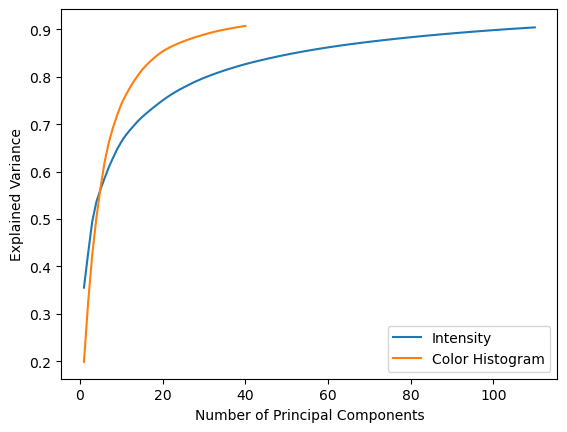

In [27]:
# plt.plot(range(1, len(cum_var_exp_all)+1), cum_var_exp_all)
plt.plot(range(1, len(cum_var_exp_intensity)+1), cum_var_exp_intensity, label="Intensity")
plt.plot(range(1, len(cum_var_exp_color_hist)+1), cum_var_exp_color_hist, label="Color Histogram")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.legend()

We can see from the above plot that the color histogram approach requires about 40 components to explain 90% of the data's variance. Meanwhile the intensity data required more than 100 principal components.

This should not be surprising, especially since the color histogram was pre-processed more intensely prior to PCA than our intensity data.

#### PCA - Visual Inspection
We can consider the first two principal components of our datasets to try to identify any clusters. 

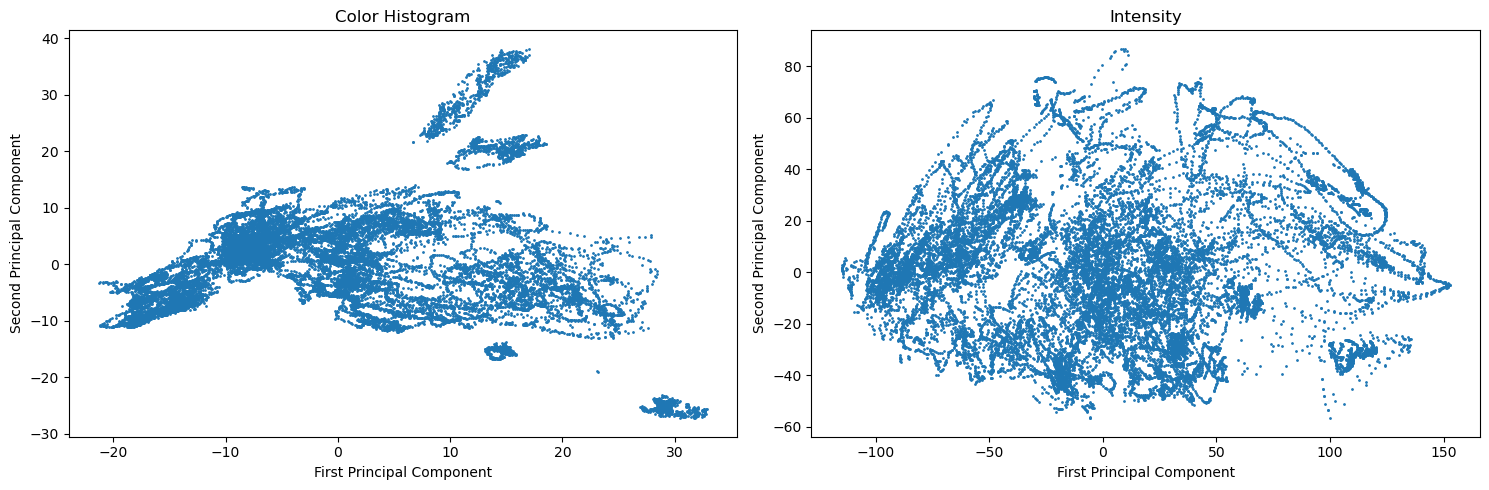

In [16]:
PC1_color, PC2_color = PCA(n_components = 2).fit_transform(color_hist_data_scaled).T
PC1_intensity, PC2_intensity = PCA(n_components = 2).fit_transform(intensity_data_scaled).T

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(PC1_color, PC2_color, s=1)
axs[0].set_xlabel("First Principal Component")
axs[0].set_ylabel("Second Principal Component")
axs[0].set_title("Color Histogram")
axs[1].scatter(PC1_intensity, PC2_intensity, s=1)
axs[1].set_xlabel("First Principal Component")
axs[1].set_ylabel("Second Principal Component")
axs[1].set_title("Intensity")
fig.tight_layout()

From the above plot, we can see 5 distinct clusters from the color histogram. The training data includes 33 types of fruits and vegetables (Apples, Apricots, Avocados, Bananas, Blueberry...), so there are likely clusters hidden within the central mass.  

It is much more challenging to distinguish clusters for the intensity data, which also shows significantly more variance across its principal components. This makes it clear why intensity data requires more principal components to explain 90% of its variance.

### Clustering

We will first fit both data sets with an arbitrary 10 clusters. We will compare K-means and agglomerative clustering methods to compare their results. After this initial comparison, we will tune the number of clusters for the color histogram and to find ideal number using the elbow method. 

#### 10 Clusters - K-Means Comparison
The below code uses our PCA results for color histograms and the intensity/greyscale dataset to create 10 clusters. We then display 10 samples from each cluster to see what similarities our model extracted.

In [17]:
from sklearn.cluster import KMeans

k_color_hist = KMeans(n_clusters = 10, n_init='auto').fit_predict(pca_color_hist)
k_intensity = KMeans(n_clusters = 10, n_init='auto').fit_predict(pca_intensity)

Below displays 10 samples from each cluster, where each row is a cluster. First up is the color histogram:

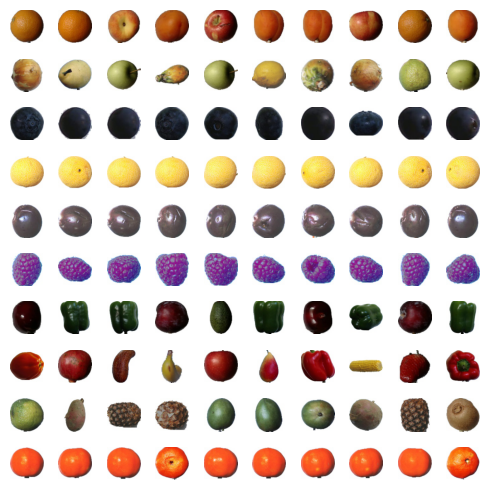

In [18]:
def display_images_clusters(image_data, cluster_labels, N_samples, N_clusters, figsize=(5,5)):   
    fig, axs = plt.subplots(N_clusters, N_samples, figsize=figsize)
    j = -1 # initialize cluster counter
    for k, ax in enumerate(axs.flatten()): # each ax is another image
        i = k % N_samples # i is a counted on the sample within a cluster. [0,1-N_clusters]
        if i == 0: # when i = 0, we have the start of a new cluster
            j += 1 # j is our cluster counter
            temp_data = image_data[cluster_labels == j] # isolate only data from our cluster
            selected_images = np.random.choice(temp_data.shape[0], N_samples, replace=False) # random sample
        ax.imshow(temp_data[selected_images[i]]) # show image
        ax.axis('off')  # Turn off axis for each subplot
    plt.tight_layout()
    plt.show()

display_images_clusters(all_data, k_color_hist, N_samples=10, N_clusters=10)

We can see clearly that isolating the color histograms from our dataset creates clusters based on color (well, duh). Since we have less clusters than the 33 source categories, we see similar foods like strawberries, apples, and bell peppers grouped together. Food with very distinct color, such as lemons or the distorted raspberries, are more easily categorized into distinct clusters.

Let's now compare to the intensity based clustering.

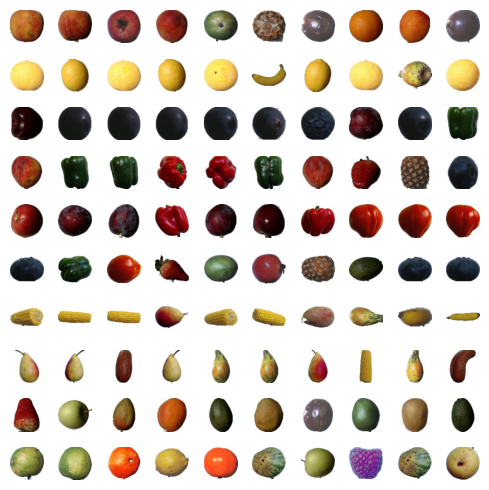

In [19]:
display_images_clusters(all_data, k_intensity, N_samples=10, N_clusters=10)

While we have the luxury of viewing the results in color, remember the intensity dataset effectively disregards all color data. With this limitation in mind, the results indicate grouping the foods by shape. The first row appears the least regular. There are other rows of neat circles and rows for different oval orientations. It further distinguishes the food based on how oblong it is, for example grouping bananas and corn images separate from apples and oranges.

While interesting, this sampling indicates our intensity approach is a bad method of dimension reduction for sorting into fruit classes. This limitation likely extends to other computer vision applications as well.

#### 33 Color Clusters
As mentioned, our training data provides 33 distinct foods. Let's test 33 clusters on our color histogram to see how well it distinguishes these categories.

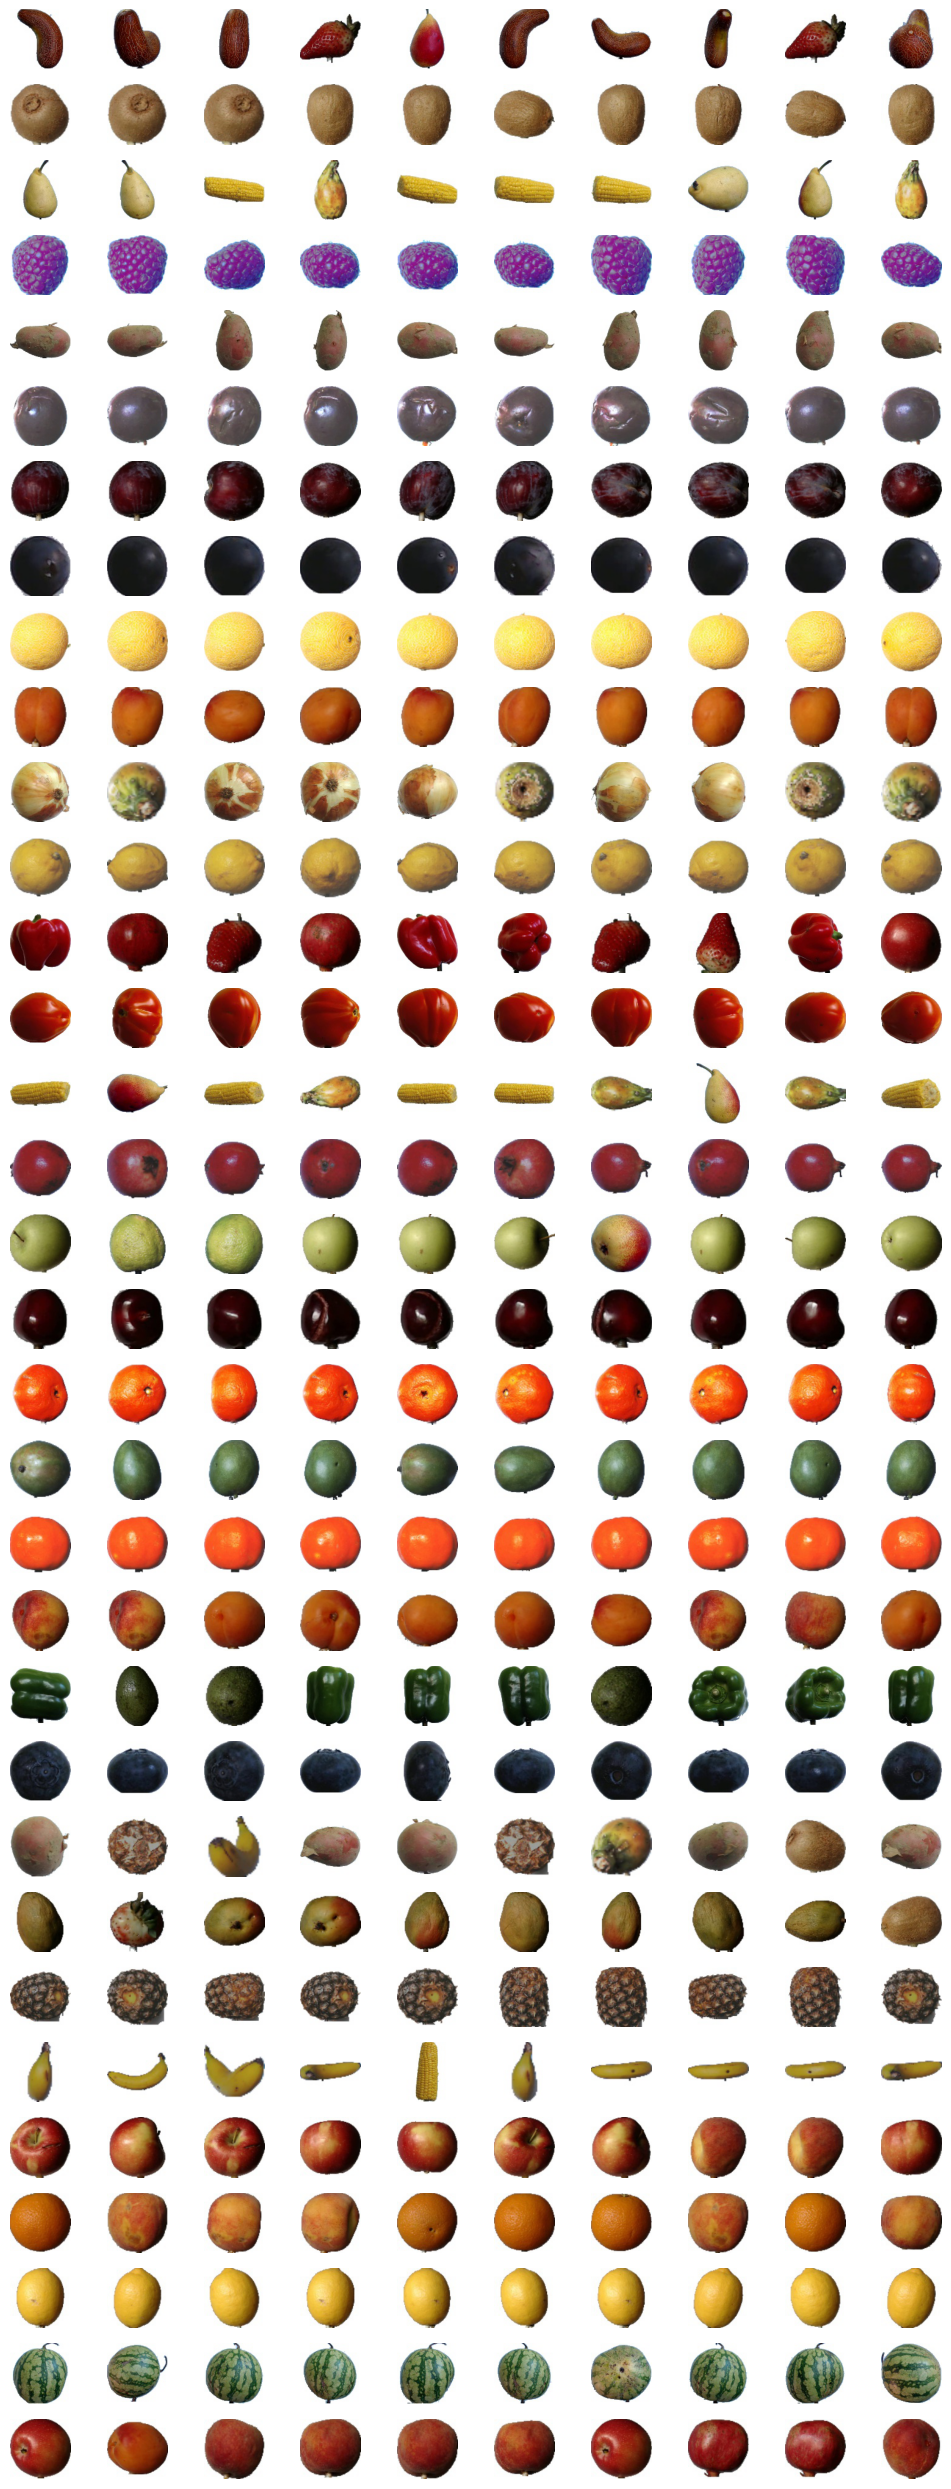

In [20]:
k_color_hist = KMeans(n_clusters = 33, n_init='auto').fit_predict(pca_color_hist)
display_images_clusters(all_data, k_color_hist, N_samples = 10, N_clusters = 33, figsize = (10,25))

We see much more clear distinction between the foods as we add more clusters. However, the model does not perfectly segment our fruit categories and still has errors. For example, there appears to be two clementine clusters, one view from the side and one from the top. There are other misclassification errors, for example grouping bananas and corn together. Interestingly, the amount of white on the image may also serve as a proxy for fruit shape, such as the oblong fruits sorted together since they have more white present than other images.

While not tested in this project, it would be interesting to compare clusters from the original unmodified data set, or the datasets without PCA to see if the clustering improves and at what cost to number of calculations/runtime.

### Agglomerative Clustering
Let's compare the more easily interpretable color histograms results to an agglomerative clustering method.

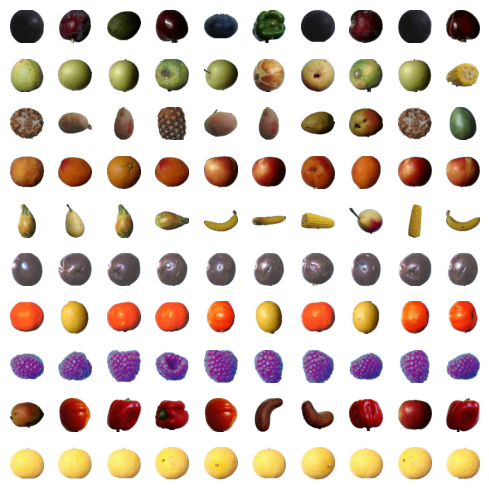

In [21]:
from sklearn.cluster import AgglomerativeClustering

ag_color_hist = AgglomerativeClustering(n_clusters = 10).fit_predict(pca_color_hist)
display_images_clusters(all_data, ag_color_hist, N_samples=10, N_clusters=10)

Our agglomerative results provide some clusters which are still very distinct (for example the lemons and raspberries), though it seems to have overall less consistency than our K-means method. In particular, lemons appear to be more often confused, appearing in a cluster of clementines and mangos. This may be improved with different metrics or linkages, but these hyperparameters won't be explored in further detail in this project.

Note the agglomerative process also took significantly more time, likely due to the large sample size and necessary point to point comparison building up to only 10 clusters. While a K-means run takes a fraction of a second, the agglomerative process took upwards of 20 seconds.

### Evaluating Inertia and Runtime vs. Number of Clusters 
Next we will tune the number of clusters hyperparameter for our color histogram to see how it improves our model and identify our 'elbow' indicating sufficient clusters.

In [22]:
import time
import pandas as pd

n = list(range(1,50))
k_inertia = []
k_runtime = []

for i in n:
    # KMeans
    k_mod = KMeans(n_clusters = i, random_state=50, n_init='auto')
    k_start = time.perf_counter()
    k_mod.fit(pca_color_hist)
    k_runtime.append(time.perf_counter() - k_start) #### append
    k_inertia.append(k_mod.inertia_) #### append

Text(0, 0.5, 'Runtime (s)')

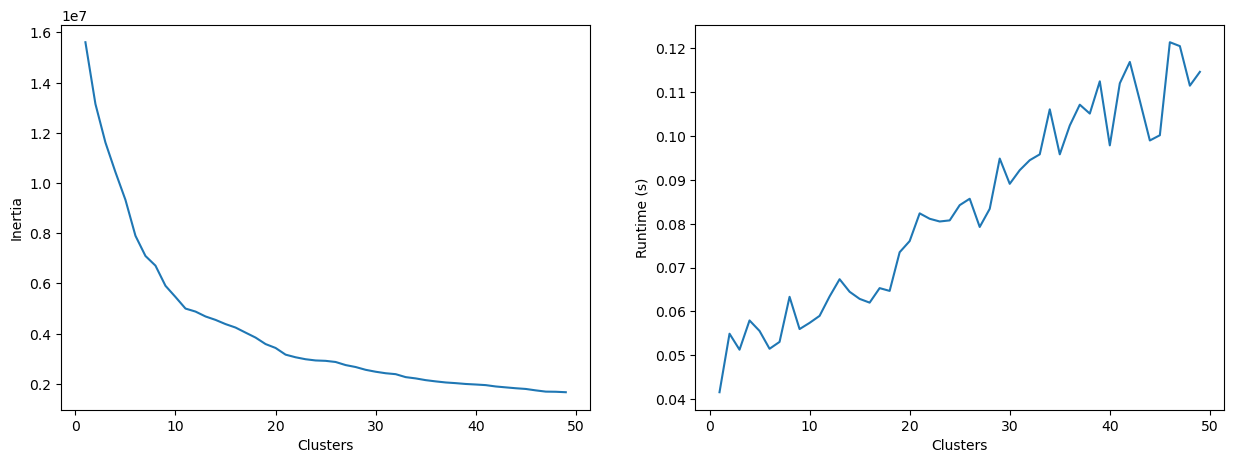

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Inertia
axs[0].plot(n,k_inertia)
axs[0].set_xlabel("Clusters")
axs[0].set_ylabel("Inertia")

# Runtime
axs[1].plot(n,k_runtime)
axs[1].set_xlabel("Clusters")
axs[1].set_ylabel("Runtime (s)")

Remember inertia is the sum of squared distance from each point to its assigned center. From our inertia plot, we see an elbow appears between 10 and 20 clusters. We also see the linear increase in runtime as we consider more clusters, though again note runtime was significantly less than the agglomerative clustering method (which consistently took 20+ seconds).

#### Visualizing our Final Clusters - PCA

For our 10 clusters, let's re-plot our primary component analysis graph to visualize our clustering result. First is our color histogram approach.

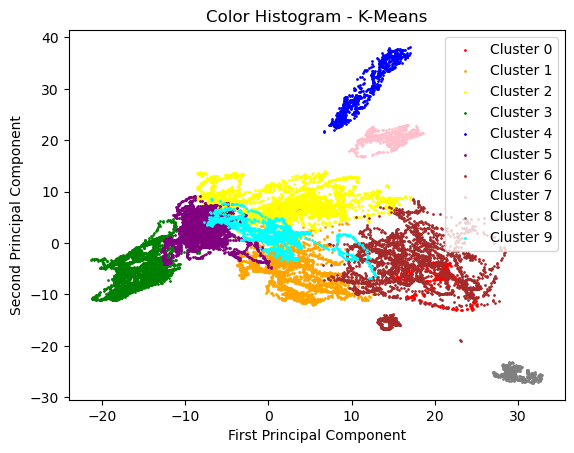

In [24]:
k_color_hist = KMeans(n_clusters = 10, n_init='auto').fit_predict(pca_color_hist)
colors = ["red", "orange", "yellow", "green", "blue", "purple", "brown", "pink", "gray", "cyan"]

for i in range(10):
    plt.scatter(PC1_color[k_color_hist == i], PC2_color[k_color_hist == i], s=1, color=colors[i], label=f'Cluster {i}')

plt.legend()
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Color Histogram - K-Means")
plt.show()

We can see good separation of the clusters we first identified, and also see the messy center which is likely where there is more misclassification.

We can create a similar plot from our agglomerative clustering method which used the same color histogram PCA results. 

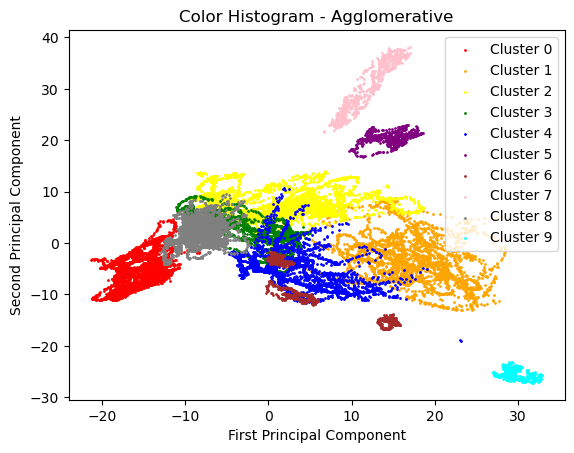

In [25]:
colors = ["red", "orange", "yellow", "green", "blue", "purple", "brown", "pink", "gray", "cyan"]

for i in range(10):
    plt.scatter(PC1_color[ag_color_hist == i], PC2_color[ag_color_hist == i], s=1, color=colors[i], label=f'Cluster {i}')

plt.legend()
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Color Histogram - Agglomerative")
plt.show()

Above we can see how the both methods reliably categorize the distinct clusters, but differ while clustering the central mass of points. There are also other disagreements, for example how the fourth smallest subcluster was associated with very different clusters among the two methods.

Let's now compare to the intensity approach, which has a different plot since it had different features.

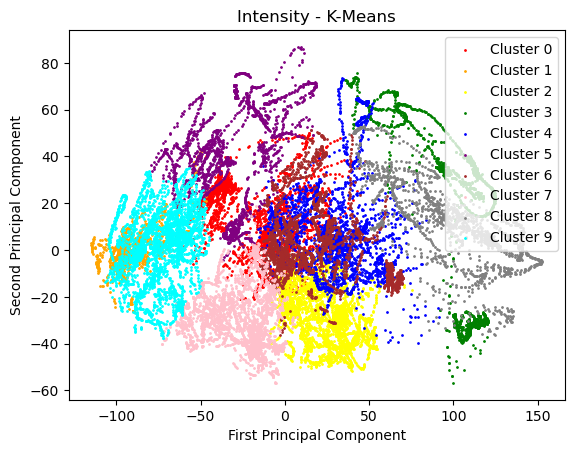

In [26]:
k_intensity = KMeans(n_clusters = 10, n_init='auto').fit_predict(pca_intensity)
colors = ["red", "orange", "yellow", "green", "blue", "purple", "brown", "pink", "gray", "cyan"]

for i in range(10):
    plt.scatter(PC1_intensity[k_intensity == i], PC2_intensity[k_intensity == i], s=1, color=colors[i], label=f'Cluster {i}')

plt.legend()
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Intensity - K-Means")
plt.show()

As we can see, this isn't the _cleanest_ clustering, especially compared to the color histogram method. Note this graph doesn't disqualify the method entirely, it instead indicates the first two principal components from the intensity dataset can't distinguish the objects enough on their own.

### Results and Analysis Summary
This project was primarily a study in dimension reduction. Dimension reduction obviously has its benefits, like simplifying a problem to the most important features which improve accuracy and reduce runtime. Of course the loss of any information is a sacrifice, but the marginal improvements far outweigh the lost resolution. The mix of approaches to develop color histograms, then perform PCA reduced our possible features from 30,000 to 765 to 40, which seemed to reasonably capture our intended clusters. Likewise the intensity approach lost all color information, which became apparent was a key feature for reliable fruit classification but may be useful for shape classification.

The most apparent result is that reducing your features to a subset of the data forces to clusters to use those features. That should be obvious, but this project was valuable to hypothesize the result, then visualize and easily interpret the algorithm's results. The PCA plots especially made it valuable to understand 1) how many possible clusters there are, and 2) where the algorithm may have issues distinguishing categories.

When comparing against agglomerative clustering, the largest distinction was the effect on runtime. Since k-means is iterative, it can quickly converge on a solution and makes it robust to rapid experimentation. Agglomerative clustering, especially in large sample, large feature cases like for the intensity dataset, runs orders of magnitude more slowly. This may be convenient, especially if you only need to run it once and can postprocess the tree later, but I didn't spend enough time with the model to develop this as a viable workflow.

### Discussion and Conclusion
The key takeaway from this analysis is the importance of experimentation to understand what is possible for an analysis or method. I also found manual feature reduction using domain knowledge satisfying, then combining with the algorithmic PCA approach for further improvement. While feature reduction is valuable, it is important to be careful not to eliminate key features accidentally. Finally, investing time in good evaluation procedures (in this case code to extract sample images from clusters) made understanding the model much easier, especially while experimenting.

While the project captured some interesting ideas, it failed to compare these results the original, flattened data. During development, there were runtime and memory issues which dropped this analysis from the scope of the project.

One insightful improvement could consider the original data as it maintains both color and position/intensity data. Minor research indicated _Incremental PCA_ as a means to avoid memory issues. Another improvement could reframe the problem to supervised learning, evaluating the resulting cluster accuracy and comparing to other supervised learning methods. Finally, one could explore the effects of reduced datasets on clustering effectiveness, though it would require more clear measurement options such as supervised accuracy to be insightful.